In [1]:
import gudhi
import wfdb 
from wfdb import processing
import numpy as np

import persistencecurves as pc

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
def quasi_attractorize(series, step):
    n = series.shape[0]

    z = []
    for i in range(n - step + 1):
        z.append(series[i:i + step].reshape(1, 3)[0])

    return np.array(z)

In [3]:
def plot_attractor(attractor):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter(xs=attractor[:, 0],
            ys=attractor[:, 1],
            zs=attractor[:, 2])
    plt.show()

In [4]:
def extract_numpy_from_diag(diagram):
    tuples = [x[1] for x in diagram]
    xs = np.array([d[0] for d in tuples])
    ys = np.array([d[1] for d in tuples])

    return np.array([xs, ys]).T

In [6]:
beat_annotations = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

non_beat_annotations = ['[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', "'", '^', '|', '~', 's', 'T', '*', 'D', '=', '"', '@']

ignore_annotations = ['Q', '?']

classes_mapping = {
    'N': 0,
    '/': 0,
    'f': 0,
    'F': 0,
    'L': 1,
    'R': 1,
    'B': 1,
    'A': 1,
    'a': 1, 
    'J': 1,
    'S': 1,
    'V': 1,
    'r': 1,
    'e': 1,
    'j': 1,
    'n': 1,
    'E': 1
}

In [7]:
annotation = wfdb.rdann('../data/arrhythmia/100', 'atr', sampfrom=0, sampto=1500)
record = wfdb.rdrecord('../data/arrhythmia/100', sampfrom=0, sampto=1500)
zero_channel_signal, resampled_ann = processing.resample_singlechan(record.p_signal[:, 0], annotation, record.fs, 200)

preprocessed_signal = processing.normalize_bound(zero_channel_signal, lb=0, ub=1)

ann_index = resampled_ann.sample

# wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds')

In [8]:
def calculate_attractors(signal, annotations, event_indexes, step):
    n = event_indexes.shape[0]

    attractors = []
    attractor_annotations = []
    for i in range(n - step + 1):
        idx1 = event_indexes[i]
        idx2 = event_indexes[i+step-1] + 1 
        
        extracted_signal = signal[idx1:idx2]
        
        attractor = quasi_attractorize(extracted_signal, step=3)
        ann = annotations[i + int(step/2)]

        attractors.append(attractor)
        attractor_annotations.append(ann)

    return attractors, attractor_annotations

In [9]:
# Skip first event 
attractors, att_annotations = calculate_attractors(preprocessed_signal, resampled_ann.symbol[1:], ann_index[1:], 3)

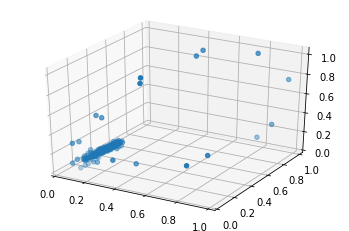

In [10]:
plot_attractor(attractors[0])

In [11]:
wfdb.show_ann_labels()

label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13      Q  

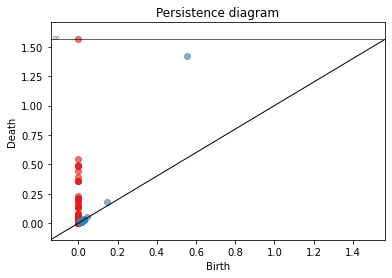

In [27]:
gudhi_complex = gudhi.RipsComplex(points=attractor)
# gudhi_complex = gudhi.AlphaComplex(points=attractor)
simplex_tree = gudhi_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()
gudhi.plot_persistence_diagram(diag)